## Question Answering System using End to End Memory Networks..sm

## Imports

In [0]:

import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Permute, dot, add, concatenate
from keras.layers import LSTM, Dense, Dropout, Input, Activation
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


### Helper functions

In [0]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


In [0]:
def parse_stories(lines):
    '''Parse stories provided in the bAbi tasks format
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            print(line)
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            # Provide all the substories
            substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


In [0]:
def get_stories(f):
    data = parse_stories(f.readlines())
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data]
    return data

In [0]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))


In [0]:
class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
! cd '/content/gdrive/My Drive/course_allocation_keywords/theOne/'

## Downloading the dataset

In [0]:
path='/content/gdrive/My Drive/course_allocation_keywords/theOne/tasks_1-20_v1-2.tar.gz'

In [0]:
tar = tarfile.open(path)

In [0]:
print(path)

/content/gdrive/My Drive/course_allocation_keywords/theOne/tasks_1-20_v1-2.tar.gz


## Getting train and test stories

In [0]:
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'

print('Extracting stories for the challenge: single_supporting_fact_10k')
train_stories = get_stories(tar.extractfile(challenge.format('train')))
test_stories = get_stories(tar.extractfile(challenge.format('test')))

Extracting stories for the challenge: single_supporting_fact_10k
Who is teaching ObjectOrientedProgramming(CS217) to sectionA Batch2018 ?	Mr.HassanMustafa	1
Who is teaching ObjectOrientedProgramming(CS217) to sectionB Batch2018 ?	Mr.HassanMustafa	2
Who is teaching ObjectOrientedProgramming(CS217) to sectionD Batch2018 ?	Ms.AtifaSarwar	2
Who is teaching ObjectOrientedProgramming(CS217) to sectionE Batch2018 ?	Dr.MuhammadArshadIslam	1
Who is teaching ObjectOrientedProgramming(CS217) to sectionF Batch2018 ?	Mr.JawadHassan	2
Who is teaching DigitalLogicDesign(EE227) to sectionA Batch2018 ?	Dr.MehwishHassan	2
Who is teaching DigitalLogicDesign(EE227) to sectionB Batch2018 ?	Dr.MehwishHassan	1
Who is teaching DigitalLogicDesign(EE227) to sectionA Batch2018 ?	Dr.MehwishHassan	2
Who is teaching DigitalLogicDesign(EE227) to sectionE Batch2018 ?	Ms.MehreenAlam	2
Who is teaching DigitalLogicDesign(EE227) to sectionF Batch2018 ?	Ms.SanaHassan	1
Who is teaching ProgrammingFundamentals(CS118) to sec

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [0]:
len(train_stories), len(test_stories)

(92, 10)

In [0]:
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
train_stories[0]

Number of training stories: 92
Number of test stories: 10


(['Mr',
  '.',
  'HassanMustafa',
  'is',
  'teaching',
  'ObjectOrientedProgramming',
  '(',
  'CS217',
  ')',
  'to',
  'sectionA',
  'Batch2018',
  'Mr',
  '.',
  'HassanMustafa',
  'is',
  'teaching',
  'ObjectOrientedProgramming',
  '(',
  'CS217',
  ')',
  'to',
  'sectionB',
  'Batch',
  '2018'],
 ['Who',
  'is',
  'teaching',
  'ObjectOrientedProgramming',
  '(',
  'CS217',
  ')',
  'to',
  'sectionA',
  'Batch2018',
  '?'],
 'Mr.HassanMustafa')

## Preprocessing the data

In [0]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))


word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)

In [0]:
print('-------------------------')
print('Vocabulary:\n',vocab,"\n")
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-------------------------')

-------------------------
Vocabulary:
 ['&', '(', ')', ') ?', ')(', '))', '-', '.', '1', '2', '2016', '2018', '?', 'A', 'AdnanSaeed', 'AdvancedAnalysisofAlgorithms', 'AdvancedDatabaseSystem', 'AdvancedMobileApplicationDevelopment', 'AdvancedQualityAssurance', 'AdvancedSoftwareRequirementsEngineering', 'AdvancedTopicsinCS', 'AmnaBasharat', 'AmnaIrum', 'AnalysisofAlgorithms', 'AppliedImageProcessing', 'ArshadAliShahid', 'AsmaAhmad', 'Aspect', 'AssemblyLanguage', 'AtifJilani', 'AtifMughees', 'AtifaSarwar', 'BasedSoftwareEngineering', 'Batch', 'Batch2015', 'Batch2016', 'Batch2017', 'Batch2018', 'BigDataAnalytics', 'Bio', 'CN501', 'CNS', 'CS', 'CS118', 'CS201', 'CS203', 'CS205', 'CS217', 'CS302', 'CS303', 'CS307', 'CS309', 'CS406', 'CS411', 'CS416', 'CS422', 'CS429', 'CS449', 'CS450', 'CS464', 'CS491', 'CS492', 'CS497', 'CS501', 'CS502', 'CS507', 'CS508', 'CS5107', 'CS5115', 'CS516', 'CS545', 'CS549', 'CS553', 'CS566', 'CS575', 'CS579', 'CS591', 'CS592', 'CS625', 'CS628', 'CS630', 'CloudCom

In [0]:
print('-------------------------')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('input train sample', inputs_train[0,:])
print('-------------------------')

-------------------------
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (92, 35)
inputs_test shape: (10, 35)
input train sample [  0   0   0   0   0   0   0   0   0   0 153   8 133 220 237 178   2  48
   3 238 222  38 153   8 133 220 237 178   2  48   3 238 223  34  12]
-------------------------


In [0]:
print('-------------------------') 
print('queries: integer tensor of shape (samples, max_length)') 
print('queries_train shape:', queries_train.shape) 
print('queries_test shape:', queries_test.shape) 
print('query train sample', queries_train[0,:]) 
print('-------------------------')

-------------------------
queries: integer tensor of shape (samples, max_length)
queries_train shape: (92, 16)
queries_test shape: (10, 16)
query train sample [  0   0   0   0   0 216 220 237 178   2  48   3 238 222  38  13]
-------------------------


In [0]:
print('-------------------------') 
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)') 
print('answers_train shape:', answers_train.shape) 
print('answers_test shape:', answers_test.shape) 
print('answer train sample', answers_train[0,:]) 
print('-------------------------')

-------------------------
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (92, 239)
answers_test shape: (10, 239)
answer train sample [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------


In [0]:
train_epochs =500
batch_size = 32
lstm_size = 64
embed_size = 50
dropout_rate = 0.3

## Building the model

In [0]:

input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)


input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(dropout_rate))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=query_maxlen))
question_encoder.add(Dropout(dropout_rate))

input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)



match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
print(match.shape)
match = Activation('softmax')(match)
print('Match shape', match.shape)


response = add([match, input_encoded_c])
response = Permute((2, 1))(response) 
print('Response shape', response)


answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer) 
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)

answer = Activation('softmax')(answer)



Input sequence: Tensor("input_1:0", shape=(?, 35), dtype=float32)
Question: Tensor("input_2:0", shape=(?, 16), dtype=float32)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Input encoded m Tensor("sequential_1/dropout_1/cond/Merge:0", shape=(?, 35, 50), dtype=float32)
Input encoded c Tensor("sequential_2/dropout_2/cond/Merge:0", shape=(?, 35, 16), dtype=float32)
Question encoded Tensor("sequential_3/dropout_3/cond/Merge:0", shape=(?, 16, 50), dtype=float32)
(?, 35, 16)
Match shape (?, 35, 16)
Response shape Tensor("permute_1/transpose:0", shape=(?, 16, 35), dtype=float32)
Answer shape Tensor("concatenate_1/concat:0", shape=(?, 16, 85), dtype=float32)


In [0]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

## Model summary

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             11950       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 16, 50)       11950       input_2[0][0]                    
____________________________________________________________________________________________

## Training the model and using Keras Callbacks for Visualization

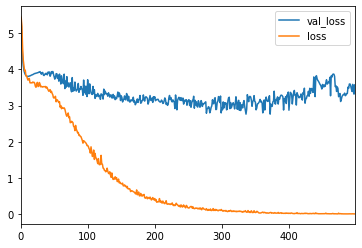

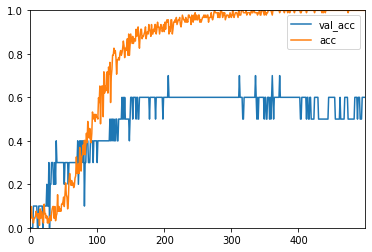

In [0]:
model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs, callbacks=[TrainingVisualizer()],
          validation_data=([inputs_test, queries_test], answers_test))

model.save('model.h5')

## Test Result Analysis

In [0]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
#import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stopwords = nltk.corpus.stopwords.words('english') 
 
def getKeywords(carr):
  sentences = nltk.sent_tokenize(carr)  
  keywords1 = []
  for sentence in sentences:
      for word,pos in nltk.pos_tag(nltk.word_tokenize(str(sentence))):
          #print(word)
          #print(pos)
          if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' or pos == 'JJ' or pos=='VB'):
              keywords1.append(word)
  return keywords1

print(getKeywords(""))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[]


In [0]:
def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += ' '+ele     
    return str1 

In [0]:
'''for i in range(0,9):
        current_inp = test_stories[i]
        current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
        current_prediction = model.predict([current_story, current_query])
        current_prediction = idx_word[np.argmax(current_prediction)]
        print(current_inp[1], '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
        print("-----------------------------------------------------------------------------------------")'''

f=open("/content/gdrive/My Drive/keywordspassed.txt","a+")
print("Test Questins: ")
print()
for i in range(0,5):
        current_inp = test_stories[i]
        current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
        current_prediction = model.predict([current_story, current_query])
        current_prediction = idx_word[np.argmax(current_prediction)]
        #print(getKeywords(current_inp[1]))
        newlist=getKeywords(listToString(current_inp[1]))
        newlist.insert(0, current_prediction)
        f.write(str(newlist))
        f.write('\n')
        print(current_inp[1], '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
        print("Keywords obtained: "+str(newlist))
        print("-----------------------------------------------------------------------------------------")

f.close()



Test Questins: 

['Who', 'is', 'teaching', 'ObjectOrientedProgramming', '(', 'CS217', ')', 'to', 'sectionB', 'Batch2018', '?'] | Prediction: Mr.HassanMustafa | Ground Truth: Mr.HassanMustafa
Keywords obtained: ['Mr.HassanMustafa', 'ObjectOrientedProgramming', 'CS217', 'sectionB', 'Batch2018']
-----------------------------------------------------------------------------------------
['Who', 'is', 'teaching', 'ObjectOrientedProgramming', '(', 'CS217', ')', 'to', 'sectionD', 'Batch2018', '?'] | Prediction: Ms.AtifaSarwar | Ground Truth: Ms.AtifaSarwar
Keywords obtained: ['Ms.AtifaSarwar', 'ObjectOrientedProgramming', 'CS217', 'sectionD', 'Batch2018']
-----------------------------------------------------------------------------------------
['Who', 'is', 'teaching', 'ObjectOrientedProgramming', '(', 'CS217', ')', 'to', 'sectionG', 'Batch2018', '?'] | Prediction: Mr.JawadHassan | Ground Truth: Dr.MuhammadArshadIslam
Keywords obtained: ['Mr.JawadHassan', 'ObjectOrientedProgramming', 'CS217', '

In [0]:
!cd '/content/gdrive/My Drive/CourseAllocation_NLG'

In [0]:
!pwd

/content


In [0]:
!python '/content/gdrive/My Drive/CourseAllocation_NLG/Preprocess.py'

loading the trainingdata...
word is:is
vec is:[0.0029908565, -0.005611216, 0.001272913, 0.0057337815, 0.0022839126, -0.005716496, -0.0034416432, 0.0012908783, 0.0051878444, -0.0026399423, 0.0021479898, 0.003740401, 0.00070125837, 0.0015759674, -0.00541148, 0.0010610822, -0.0048944154, -0.0014093607, 0.0071510975, 0.006123376]
word is:teaching
vec is:[0.0017073717, -0.0063373107, 0.0014816516, -0.0027730253, -0.0015577088, -0.0010480471, -0.0039894646, 0.004920112, -0.0016645017, -0.006385385, 0.0019459097, 0.0007838716, 3.319858e-05, 0.0048840856, -0.002878282, 0.0033324722, -0.00065790414, -0.0039664265, 0.0027801935, 0.0048284098]
word is:ObjectOrientedProgramming(CS217)
vec is:[-0.0044510607, -0.0023137503, 0.0004056745, 0.00042450827, 0.0012427332, -0.0018964204, 0.0010213383, -0.0021397872, -0.0042437017, 0.0008233451, -0.0031324897, 0.0018407407, 0.0051926286, -0.0010638152, 0.0035242906, -0.0007377006, 0.0018892129, -0.0012923967, -0.0023077694, -0.0013333376]
word is:to
vec is:

In [0]:
!pip install tensorflow==1.10

     |████████████████████████████████| 58.4MB 50kB/s 
     |████████████████████████████████| 3.3MB 60.5MB/s 
     |████████████████████████████████| 12.2MB 50.4MB/s 
     |████████████████████████████████| 573kB 55.9MB/s 
ERROR: spacy 2.1.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.10.0 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: google-auth 1.7.2 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: fastai 1.0.60 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: cvxpy 1.0.25 ha

In [0]:
!python '/content/gdrive/My Drive/CourseAllocation_NLG/train.py'

Streaming output truncated to the last 5000 lines.
Epoch: 307 Learning rate: 0.0010
5-step perplexity: 1.103 cost-time: 0.09 s
10-step perplexity: 1.085 cost-time: 0.08 s
15-step perplexity: 1.086 cost-time: 0.07 s
20-step perplexity: 1.084 cost-time: 0.08 s
25-step perplexity: 1.080 cost-time: 0.07 s
Epoch: 307 Train Perplexity: 1.083
Epoch: 308 Learning rate: 0.0010
5-step perplexity: 1.054 cost-time: 0.10 s
10-step perplexity: 1.074 cost-time: 0.08 s
15-step perplexity: 1.072 cost-time: 0.07 s
20-step perplexity: 1.073 cost-time: 0.07 s
25-step perplexity: 1.077 cost-time: 0.08 s
Epoch: 308 Train Perplexity: 1.074
Epoch: 309 Learning rate: 0.0010
5-step perplexity: 1.105 cost-time: 0.09 s
10-step perplexity: 1.086 cost-time: 0.07 s
15-step perplexity: 1.089 cost-time: 0.08 s
20-step perplexity: 1.089 cost-time: 0.08 s
25-step perplexity: 1.084 cost-time: 0.08 s
Epoch: 309 Train Perplexity: 1.087
Epoch: 310 Learning rate: 0.0010
5-step perplexity: 1.060 cost-time: 0.09 s
10-step perp

In [0]:
!python '/content/gdrive/My Drive/CourseAllocation_NLG/generation.py'

Enter Keywords:
Dr.MehwishHassan
DigitalLogicDesign
EE227
Batch2018
sectionA
Repeat
['Dr.MehwishHassan', 'DigitalLogicDesign', 'EE227', 'Batch2018', 'sectionA', 'Repeat']
2020-03-09 21:28:58.866006: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
model loading ...
Done!
b'Dr.MehwishHassan is teaching DigitalLogicDesign(EE227) to sectionA Batch2018 Repeat  '
